In [1]:
import warnings
warnings.filterwarnings("ignore")

from sklearn._config import set_config
set_config(print_changed_only=False)

In [2]:
import pandas as pd

df = pd.read_csv('./bike.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [3]:
df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32


- datetime: hourly date + timestamp
- season: 1=봄, 2-여름, 3=가을, 4=겨울
- holiday: 1=주말이 아닌 휴일, 0=휴일이 아닌 날
- workingday: 1=주말/휴일이 아닌 주중, 0=주말 및 휴일
- weather
  - 1 = 맑음, 약간 구름 낀 흐림
  - 2 = 안개, 안개 + 흐림
  - 3 = 가벼운 눈, 가벼운 비 + 천둥
  - 4 = 심한 눈/비, 천둥/번개
- temp: 온도(섭씨)
- atemp: 체감온도(섭씨)
- humidity: 상대습도
- windspeed: 풍속
- casual: 사전에 등록되지 않은 사용자가 대여한 횟수
- registered: 사전에 등록된 사용자가 대여한 횟수
- count: 대여 횟수

### 데이터 클렌징 및 가공, 데이터 시각화

In [4]:
df['datetime'] = df.datetime.apply(pd.to_datetime)

df['year'] = df.datetime.apply(lambda x : x.year)
df['month'] = df.datetime.apply(lambda x : x.month)
df['day'] = df.datetime.apply(lambda x : x.day)
df['hour'] = df.datetime.apply(lambda x: x.hour)

df.head(3)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2


In [5]:
drop_columns = ['datetime','casual','registered']
df.drop(drop_columns, axis=1, inplace=True)

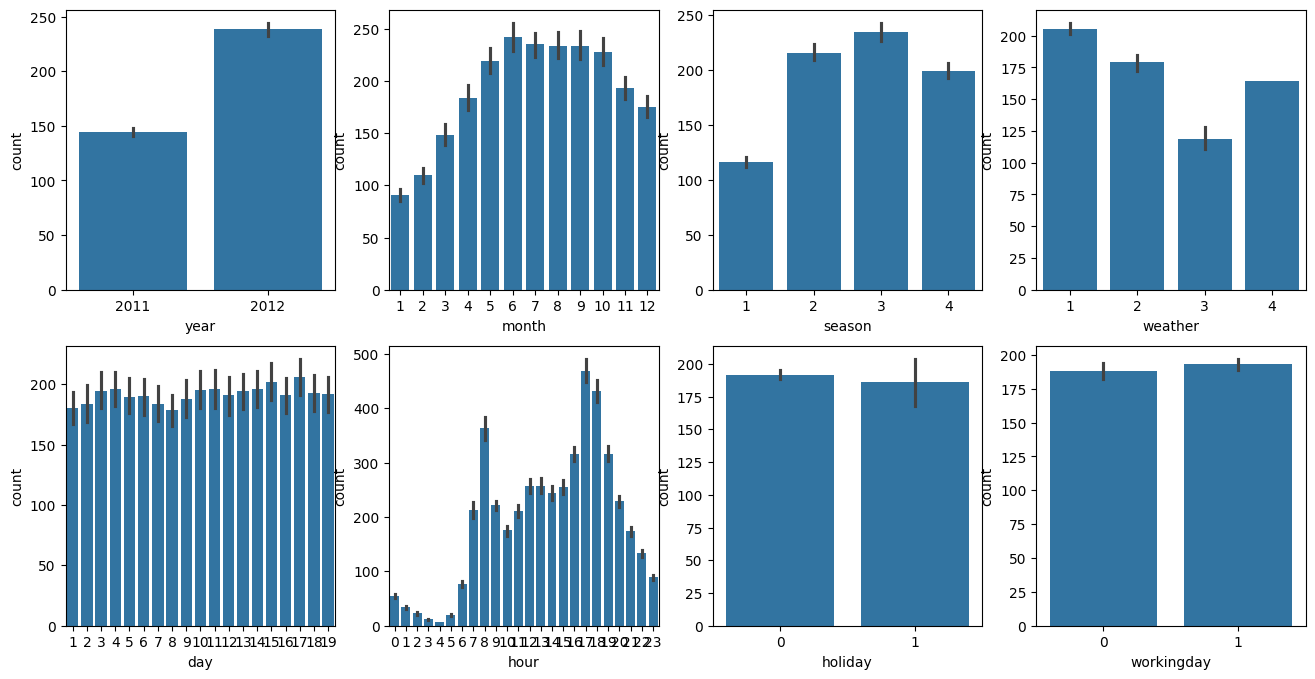

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(figsize=(16, 8), ncols=4, nrows=2)

cat_features = ['year', 'month', 'season', 'weather', 'day', 'hour', 'holiday', 'workingday']
for i, feature in enumerate(cat_features):
    row = int(i/4)
    col = i%4
    
    sns.barplot(x=feature, y='count', data=df, ax=axs[row][col])

- 사이킷런에서 RMSLE(Root Mean Square Log Error)를 지원하지 않으므로 직접 구현
  - log가 아닌 log1p 이용해야 함 (1+ log)

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def rmsle(y, pred):
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    
    return rmsle


def rmse(y, pred):
    return np.sqrt(mean_squared_error(y,pred))


def evaluate_regr(y, pred):
    rmsle_val = rmsle(y, pred)
    rmse_val = rmse(y, pred)
    
    mae_val = mean_absolute_error(y, pred)
    
    print('RMSLE: {0:.3f}, RMSE: {1:.3F}, MAE: {2:.3F}'.format(rmsle_val, rmse_val, mae_val))

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

target_y = df['count']
features_X = df.drop(['count'], axis=1, inplace=False)

train_X, test_X, train_y, test_y = train_test_split(features_X, target_y, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(train_X, train_y)

predicts = lr_reg.predict(test_X)

evaluate_regr(test_y, predicts)

RMSLE: 1.174, RMSE: 141.261, MAE: 105.676


In [9]:
def get_top_error_data(test_y, predicts, n_tops = 5):
    result_df = pd.DataFrame(test_y.values, columns=['real_count'])
    
    result_df['predicted_count']= np.round(predicts)
    result_df['diff'] = np.abs(result_df['real_count'] - result_df['predicted_count'])
    
    print(result_df.sort_values('diff', ascending=False)[:n_tops])
    
get_top_error_data(test_y, predicts, n_tops=5)

      real_count  predicted_count   diff
1094         977            391.0  586.0
361          948            366.0  582.0
1872         890            325.0  565.0
1654         888            327.0  561.0
1841         884            326.0  558.0


<Axes: >

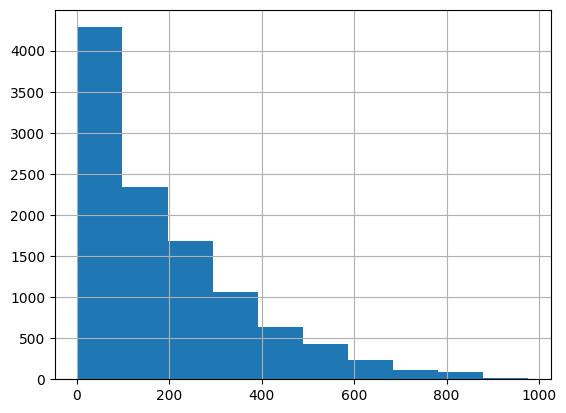

In [10]:
target_y.hist()

<Axes: >

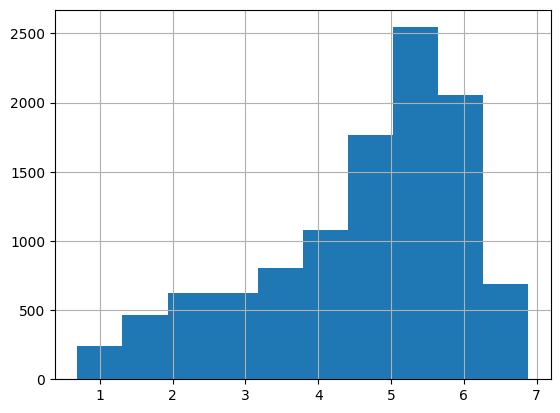

In [11]:
y_log_transform = np.log1p(target_y)
y_log_transform.hist()

In [12]:
target_y_log = np.log1p(target_y)

train_X, test_X, train_y, test_y = train_test_split(features_X, target_y_log, test_size=0.3, random_state=42)

lr_reg = LinearRegression()
lr_reg.fit(train_X, train_y)

predicts = lr_reg.predict(test_X)

test_y_exp = np.expm1(test_y)
predicts_exp = np.expm1(predicts)

evaluate_regr(test_y_exp ,predicts_exp)

RMSLE: 1.020, RMSE: 160.730, MAE: 108.236


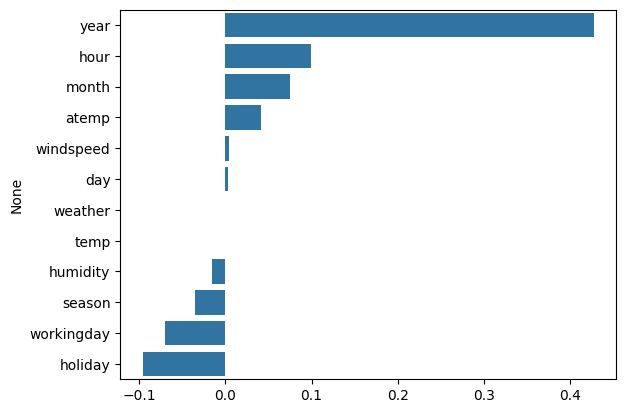

In [13]:
coef = pd.Series(lr_reg.coef_, index=features_X.columns)
coef_sort = coef.sort_values(ascending=False)

sns.barplot(x=coef_sort.values, y=coef_sort.index)
plt.savefig('log_transform.tif', format='tif', dpi=300, bbox_inches='tight')

In [14]:
features_ohe = ['year', 'month','day', 'hour', 'holiday', 'workingday','season','weather']
features_X_ohe = pd.get_dummies(features_X, columns=features_ohe)

train_X, test_X, train_y, test_y = train_test_split(features_X_ohe, target_y_log, test_size=0.3, random_state=42)

def get_model_predict(model, train_X, test_X, train_y, test_y, is_expm1=False):
    model.fit(train_X, train_y)
    
    predicts = model.predict(test_X)
    if is_expm1:
        test_y = np.expm1(test_y)
        predicts = np.expm1(predicts)
        
    print('###',model.__class__.__name__,'###')
    evaluate_regr(test_y, predicts)


lr_reg = LinearRegression()
ridge_reg = Ridge(alpha=10)
lasso_reg = Lasso(alpha=0.01)

for model in [lr_reg, ridge_reg, lasso_reg]:
    get_model_predict(model, train_X, test_X, train_y, test_y, is_expm1=True)

### LinearRegression ###
RMSLE: 0.585, RMSE: 95.846, MAE: 62.352
### Ridge ###
RMSLE: 0.587, RMSE: 96.827, MAE: 62.889
### Lasso ###
RMSLE: 0.639, RMSE: 112.044, MAE: 71.914


<Axes: ylabel='None'>

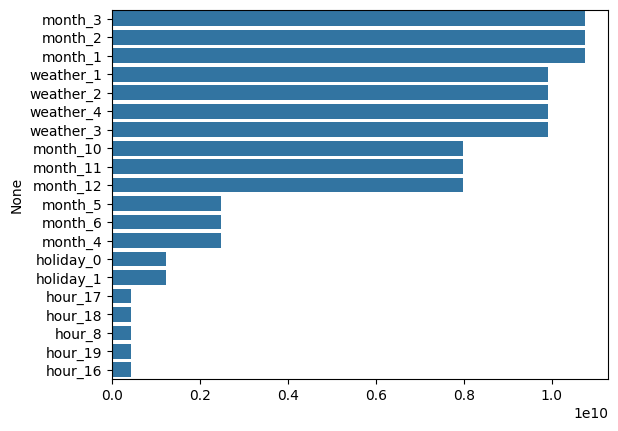

In [15]:
coef = pd.Series(lr_reg.coef_ , index=features_X_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]

sns.barplot(x=coef_sort.values , y=coef_sort.index)

In [16]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

rf_reg = RandomForestRegressor(n_estimators=500)
gbm_reg = GradientBoostingRegressor(n_estimators=500)
xgb_reg = XGBRegressor(n_estimators=500)
lgbm_reg = LGBMRegressor(n_estimators=500)

for model in [rf_reg, gbm_reg, xgb_reg, lgbm_reg]:
    get_model_predict(model, train_X.values, test_X.values, train_y.values, test_y.values, is_expm1=True)

### RandomForestRegressor ###
RMSLE: 0.349, RMSE: 48.052, MAE: 30.052
### GradientBoostingRegressor ###
RMSLE: 0.331, RMSE: 51.694, MAE: 32.193
### XGBRegressor ###
RMSLE: 0.344, RMSE: 52.341, MAE: 32.070
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 347
[LightGBM] [Info] Number of data points in the train set: 7620, number of used features: 72
[LightGBM] [Info] Start training from score 4.585795
### LGBMRegressor ###
RMSLE: 0.314, RMSE: 44.509, MAE: 27.586
